In [11]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# 設定設備為MPS（如果你的設備支援）
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 資料路徑
train_def_front = "/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/train/def_front"
train_ok_front = "/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/train/ok_front"
test_def_front = "/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/test/def_front"
test_ok_front = "/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/test/ok_front"

# 定義資料轉換
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 載入訓練資料
train_data = ImageFolder(root='/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/train', transform=transform)

# 載入測試資料
test_data = ImageFolder(root='/Users/linyinghsiao/Desktop/github專案/鑄造產品質量檢查/data/casting_data/test', transform=transform)

# 資料分割
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# 建立資料加載器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [18]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

model = CNN().to(device)


In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # 驗證模型
    model.eval()
    val_labels = []
    val_preds = []
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(preds.cpu().numpy())
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1, Loss: 0.0138, Train Accuracy: 0.9955, Val Loss: 0.0171, Val Accuracy: 0.9947
Epoch 2, Loss: 0.0134, Train Accuracy: 0.9962, Val Loss: 0.0266, Val Accuracy: 0.9917
Epoch 3, Loss: 0.0122, Train Accuracy: 0.9957, Val Loss: 0.0139, Val Accuracy: 0.9955
Epoch 4, Loss: 0.0072, Train Accuracy: 0.9975, Val Loss: 0.0195, Val Accuracy: 0.9932
Epoch 5, Loss: 0.0071, Train Accuracy: 0.9979, Val Loss: 0.0234, Val Accuracy: 0.9910
Epoch 6, Loss: 0.0119, Train Accuracy: 0.9960, Val Loss: 0.0310, Val Accuracy: 0.9879
Epoch 7, Loss: 0.0105, Train Accuracy: 0.9968, Val Loss: 0.0284, Val Accuracy: 0.9887
Epoch 8, Loss: 0.0090, Train Accuracy: 0.9975, Val Loss: 0.0192, Val Accuracy: 0.9932
Epoch 9, Loss: 0.0344, Train Accuracy: 0.9870, Val Loss: 0.0334, Val Accuracy: 0.9879
Epoch 10, Loss: 0.0102, Train Accuracy: 0.9970, Val Loss: 0.0178, Val Accuracy: 0.9955


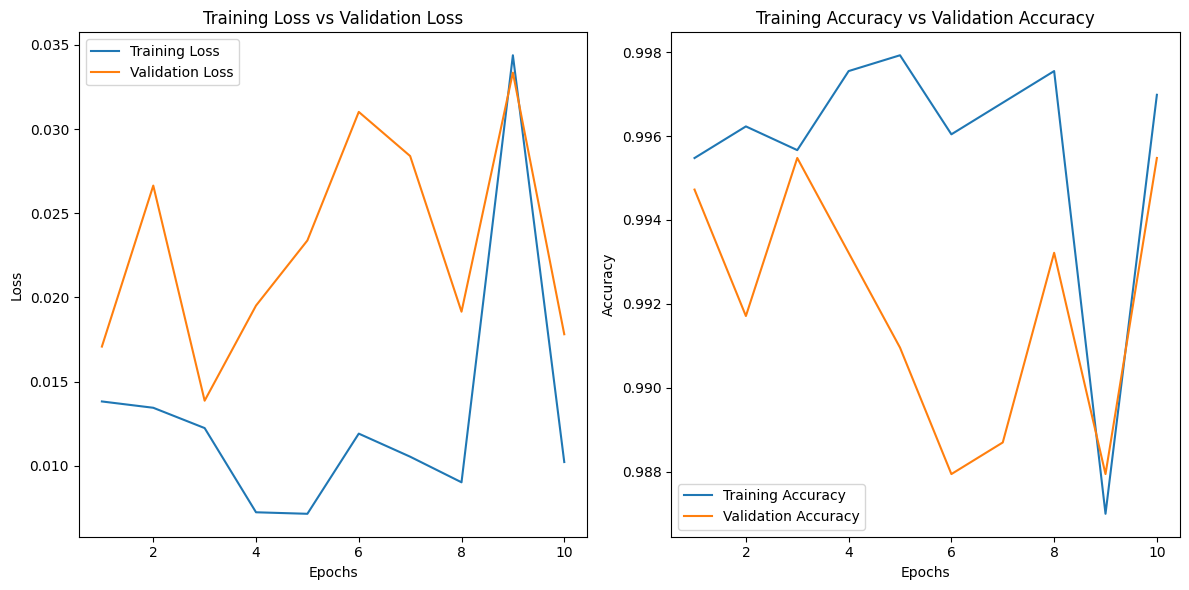

In [25]:
# 畫圖比較 training loss vs validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()

# 畫圖比較 training accuracy vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
